In [1]:
''' This transformer implements sequence generation with sequences of floats. The model task here is adding up
    neighbors in the sequences, where x is the input and y is the desired output
    
    x: {SOS, x1, x2, x3, ..., xn, EOS} --> y: {SOS, y1, y2, ..., yn-1, EOS}
    
    where y is defined as
    
    y = {SOS, y1, y2, ..., yn-1, EOS } = {SOS, x1+x2, x2+x3, ..., xn-1+xn, EOS}

    Right now, this implementation uses a dropout probability of 0 (i.e. doesn't use dropout at all for training or
    verification) and uses no positional encoding
'''


import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import copy
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Generate data
N = 100000
seq_len = 4
SOS_token = np.pi
EOS_token = -np.pi

# Generate data
data = torch.rand((N, seq_len))

# Generate target
target = torch.zeros((N, seq_len-1))
for i in range(seq_len-1):
    target[:, i] = data[:, i] + data[:, i+1]
    
# Append SOS and EOS token
SOS_ = SOS_token*torch.ones((N, 1))
EOS_ = EOS_token*torch.ones((N, 1))

data = torch.cat((SOS_, data), axis=1)
data = torch.cat((data, EOS_), axis=1)

target = torch.cat((SOS_, target), axis=1)
target = torch.cat((target, EOS_), axis=1)

# Unsqueeze so each entry becomes its own dimension, needed for the nn.Linear embedding
data = torch.unsqueeze(data, dim=2)
target = torch.unsqueeze(target, dim=2)

# Batching
def batchify(data, target):
    numMiniBatch = int(math.floor(data.shape[0]/100.0))
    inputMiniBatches = data.chunk(numMiniBatch)
    outputMiniBatches = target.chunk(numMiniBatch)
    
    return numMiniBatch, inputMiniBatches, outputMiniBatches

batch_num, data_batches, tgt_batches = batchify(data, target)

In [2]:
## Right now, training the network over this 
SOS_token = np.pi
EOS_token = -np.pi

N = 250000

def generateSeqs(N, seq_len):
    
    data = torch.rand((N, seq_len))
    target = torch.zeros((N, seq_len-1))
    for i in range(seq_len-1):
        target[:, i] = data[:, i] + data[:, i+1]
        
    # Append SOS and EOS token
    SOS_ = SOS_token*torch.ones((N, 1))
    EOS_ = EOS_token*torch.ones((N, 1))

    data = torch.cat((SOS_, data), axis=1)
    data = torch.cat((data, EOS_), axis=1)

    target = torch.cat((SOS_, target), axis=1)
    target = torch.cat((target, EOS_), axis=1)

    # Unsqueeze so each entry becomes its own dimension, needed for the nn.Linear embedding
    data = torch.unsqueeze(data, dim=2)
    target = torch.unsqueeze(target, dim=2)
    
    return data, target

def generateVarSeqs(N, len_min=2, len_max=8):
    
    batch_num = len_max - len_min
    batch_size = int(N/batch_num)
    
    data = []
    target = []
    
    for i in np.arange(len_min, len_max+1, 1):
        data_i, target_i = generateSeqs(batch_size, i)
        data.append(data_i)
        target.append(target_i)
    
    data = tuple(data)
    target = tuple(target)
    
    return data, target, batch_num

data_batches, tgt_batches, batch_num = generateVarSeqs(N)

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_p, max_len):
        super().__init__()

        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.long).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, d_model, 2).long() * (-math.log(10000.0)) / d_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/d_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/d_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor, train=False) -> torch.tensor:
        # Residual connection + pos encoding
        if train:
            return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
        else:
            return token_embedding + self.pos_encoding[:token_embedding.size(0), :]

    
class TransformerModel(nn.Module):
    def __init__(self, d_model, n_head, n_layers):
        super().__init__()
        
        self.d_model = d_model
        self.positional_encoder = PositionalEncoding(
            d_model = d_model, 
            dropout_p = 0.0,
            max_len = 100)
        self.embedding = nn.Linear(1, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=n_head,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dropout = 0 )
        
        self.out = nn.Linear(d_model, 1) # Learned linear at the end where output of decoder is run through
        
    def get_tgt_mask(self, size):
    
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        return mask
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, verbose=False, train=False):
        
        if verbose:
            print(f'\nTracing through the Transformer\n')
            print(f'Input: {src}')
            print(f'Target: {tgt}')
            
        src = (self.embedding(src) * math.sqrt(self.d_model)).to(device)
        tgt = (self.embedding(tgt) * math.sqrt(self.d_model)).to(device)
        
        if verbose:
            print(f'\nAfter Embeddings')
            print(f'Embedded input: {src}')
            print(f'Embedded target: {tgt}')
        
        #src = self.positional_encoder(src, train=train)
        #tgt = self.positional_encoder(tgt, train=train)
        
        if verbose:
            print(f'\nAfter Positional Encoding')
            print(f'Positionally encoded input: {src}')
            print(f'Positionally encoded target: {tgt}')
            
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        
        transformer_output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask).to(device)
        
        if verbose:
            print(f'\nAfter Encoder + Decoder Blocks')
            print(f'Output from transformer: {transformer_output}')
            
        output = self.out(transformer_output).to(device)
    
        output = output.permute(1, 0, 2).to(device)
        
        if verbose:
            print(f'Final output: {output}')
        
        return output

In [4]:
# Define the model
d_model = 16
n_head = 1
n_layers = 1

model = TransformerModel(d_model, n_head, n_layers).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [5]:
# Training
def train(model, data_batches, target_batches, num_batch, verbose=False):
    model.train()
    total_loss = 0

    for i in range(num_batch):
        data = data_batches[i].to(device)
        target = target_batches[i].to(device)
        
        target_in = target[:, :-1].to(device)
        target_expected = target[:, 1:].to(device)
        
        sequence_length = target_in.size(1)

        tgt_mask = model.get_tgt_mask(sequence_length).to(device)
        src_mask = model.get_tgt_mask(data.size(1)).to(device)
        
        pred = model(data, target_in, src_mask, tgt_mask, train=True)
        #pred = torch.permute(pred, (0, 2, 1)).to(device)
        
        if i == 0 and verbose:
            print('data', data)
            print('tgt in', target_in)
            print('pred', pred)
            print('expected', target_expected)
        
        loss = (criterion(pred, target_expected).type(torch.float))
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()
        
    return total_loss
    
def train_loop(model, n_epochs, data, target, num_batch):
    best_loss = 10000.0
    best_model = copy.deepcopy(model).to(device)
    loss_ = np.array([])
    epochs = np.array([])
    
    for i in range(n_epochs):
        loss = train(model, data, target, num_batch)
        loss_ = np.append(loss_, loss)
        epochs = np.append(epochs, i)
        
        if loss < best_loss:
            best_loss = loss
            best_model = copy.deepcopy(model).to(device)
                     
        if i % 10 == 0:
            print(f'Epoch: {i}\nTotal Loss: {loss}')
            print(f'----------------------------------')
    
    return best_model, loss_, epochs

In [6]:
n_epochs = 250
best_model, loss_, epochs = train_loop(model, n_epochs, data_batches, tgt_batches, batch_num)

Epoch: 0
Total Loss: 669.4080870375037
----------------------------------
Epoch: 10
Total Loss: 2562.4878367334604
----------------------------------
Epoch: 20
Total Loss: 23.053058171644807
----------------------------------
Epoch: 30
Total Loss: 5.437676399247721
----------------------------------
Epoch: 40
Total Loss: 1.3566166934615467
----------------------------------
Epoch: 50
Total Loss: 0.4853938206942985
----------------------------------
Epoch: 60
Total Loss: 1.9199955041403882
----------------------------------
Epoch: 70
Total Loss: 0.16302701808308484
----------------------------------
Epoch: 80
Total Loss: 0.16826452171517303
----------------------------------
Epoch: 90
Total Loss: 0.09125664264956868
----------------------------------
Epoch: 100
Total Loss: 0.5038538226217497
----------------------------------
Epoch: 110
Total Loss: 0.11292940563907905
----------------------------------
Epoch: 120
Total Loss: 0.34951719015225535
----------------------------------
Epoch: 

KeyboardInterrupt: 

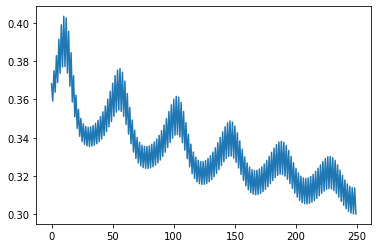

In [10]:
plt.plot(epochs, loss_)
plt.show()

In [23]:
# Testing
data_ex = torch.tensor([[[np.pi], [0.3], [0.3], [0.2], [0.5], [-np.pi]]]).to(device)
tgt_in = torch.tensor([[[np.pi], [0.6005]]]).to(device)

sequence_length = tgt_in.size(1)

# It seems to really need both the src and tgt masks to work even when using the model for extrapolation, not training
tgt_mask = model.get_tgt_mask(sequence_length).to(device)
src_mask = model.get_tgt_mask(data_ex.size(1)).to(device)

output = model(data_ex, tgt_in, src_mask, tgt_mask, train=False)
print(output)

tensor([[[0.6005],
         [0.4979]]], device='cuda:0', grad_fn=<PermuteBackward0>)
